# Data Processing and Modeling for Zillow's Home Value Prediction

The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016

The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.

You are asked to predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

Not all the properties are sold in each time period. If a property was not sold in a certain time period, that particular row will be ignored when calculating your score.

In [5]:
%load_ext autoreload
%autoreload 2
import src.data_proc as data_proc

import numpy as np
import pandas as pd
import sys
import os
import gc
import random
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
pd.options.display.float_format

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [6]:
%%time
# Load in properties data
prop_2016 = data_proc.load_properties_data("data/properties_2016.csv")
prop_2017 = data_proc.load_properties_data("data/properties_2017.csv")

assert len(prop_2016) == len(prop_2017)
print("Number of properties: {}".format(len(prop_2016)))
print("Number of property features: {}".format(len(prop_2016.columns)-1))

Number of properties: 2985217
Number of property features: 57
CPU times: user 35.7 s, sys: 6.9 s, total: 42.6 s
Wall time: 42.8 s


In [7]:
# Load in training data (with logerror labels)
train_2016 = data_proc.load_training_data("data/train_2016_v2.csv")
train_2017 = data_proc.load_training_data("data/train_2017.csv")

print("Number of 2016 transaction records: {}".format(len(train_2016)))
print("Number of 2016 transaction records: {}".format(len(train_2017)))
print("\n", train_2016.head())
print("\n", train_2017.head())

Number of 2016 transaction records: 90275
Number of 2016 transaction records: 77613

    parcelid  logerror transactiondate
0  11016594    0.0276      2016-01-01
1  14366692   -0.1684      2016-01-01
2  12098116   -0.0040      2016-01-01
3  12643413    0.0218      2016-01-02
4  14432541   -0.0050      2016-01-02

    parcelid  logerror transactiondate
0  14297519  0.025595      2017-01-01
1  17052889  0.055619      2017-01-01
2  14186244  0.005383      2017-01-01
3  12177905 -0.103410      2017-01-01
4  10887214  0.006940      2017-01-01


In [8]:
# Rename & retype the feature columns; also unify representations of missing values
def get_landuse_code_df(prop_2016, prop_2017):
    temp = prop_2016.groupby('county_landuse_code')['county_landuse_code'].count()
    landuse_codes = list(temp[temp >= 300].index)
    temp = prop_2017.groupby('county_landuse_code')['county_landuse_code'].count()
    landuse_codes += list(temp[temp >= 300].index)
    landuse_codes = list(set(landuse_codes))
    df_landuse_codes = pd.DataFrame({'county_landuse_code': landuse_codes,
                                     'county_landuse_code_id': range(len(landuse_codes))})
    return df_landuse_codes

def get_zoning_desc_code_df(prop_2016, prop_2017):
    temp = prop_2016.groupby('zoning_description')['zoning_description'].count()
    zoning_codes = list(temp[temp >= 5000].index)
    temp = prop_2017.groupby('zoning_description')['zoning_description'].count()
    zoning_codes += list(temp[temp >= 5000].index)
    zoning_codes = list(set(zoning_codes))
    df_zoning_codes = pd.DataFrame({'zoning_description': zoning_codes,
                                     'zoning_description_id': range(len(zoning_codes))})
    return df_zoning_codes

def process_columns(df, df_landuse_codes, df_zoning_codes):
    df = df.merge(how='left', right=df_landuse_codes, on='county_landuse_code')
    df = df.drop(['county_landuse_code'], axis=1)
    
    df = df.merge(how='left', right=df_zoning_codes, on='zoning_description')
    df = df.drop(['zoning_description'], axis=1)
    
    df.loc[df.county_id == 3101, 'county_id'] = 0
    df.loc[df.county_id == 1286, 'county_id'] = 1
    df.loc[df.county_id == 2061, 'county_id'] = 2
    return df

data_proc.rename_columns(prop_2016)
data_proc.rename_columns(prop_2017)

df_landuse_codes = get_landuse_code_df(prop_2016, prop_2017)
df_zoning_codes = get_zoning_desc_code_df(prop_2016, prop_2017)
prop_2016 = process_columns(prop_2016, df_landuse_codes, df_zoning_codes)
prop_2017 = process_columns(prop_2017, df_landuse_codes, df_zoning_codes)

data_proc.retype_columns(prop_2016)
data_proc.retype_columns(prop_2017)

prop_2017.head()

,parcelid,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,county_landuse_code_id,zoning_description_id
0,10754147,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34144440.0,-118654080.0,85768.0,NaN,NaN,NaN,NaN,NaN,238,60378004.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN,47,-1
1,10759547,-1,-1,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34140432.0,-118625360.0,4083.0,NaN,NaN,NaN,NaN,NaN,230,60378000.0,37688.0,0,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,38,10
2,10843547,-1,-1,NaN,0.0,0.0,4,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,33989360.0,-118394632.0,63085.0,NaN,NaN,NaN,NaN,NaN,16,60377032.0,51617.0,0,NaN,96095.0,0.0,NaN,NaN,-1,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.369141,NaN,NaN,NaN,27,6
3,10859147,-1,-1,NaN,0.0,0.0,2,6.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34148864.0,-118437208.0,7521.0,NaN,NaN,NaN,NaN,NaN,16,60371412.0,12447.0,0,27080.0,96424.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.570312,NaN,NaN,NaN,27,6
4,10879947,-1,-1,NaN,0.0,0.0,3,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,0,60371232.0,12447.0,0,46795.0,96450.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.169922,NaN,NaN,NaN,23,-1


In [9]:
# Join the training data with the property table
train_2016 = train_2016.merge(how='left', right=prop_2016, on='parcelid')
train_2017 = train_2017.merge(how='left', right=prop_2017, on='parcelid')

# Remove outliers from training set
threshold = 0.4
print("Remove outliers for 2016 training set:")
train_2016 = data_proc.remove_outliers(train_2016, threshold)
print("\nRemove outliers for 2017 training set:")
train_2017 = data_proc.remove_outliers(train_2017, threshold)

# Combine the 2016 and 2017 training sets
train = pd.concat([train_2016, train_2017], axis=0, ignore_index=True)
print("\nCombined training set size: {}".format(len(train)))

train.head(20)

Remove outliers for 2016 training set:
90275 training examples in total
1844 with abs(logerror) > 0.4
New training set size (outliers removed): 88431

Remove outliers for 2017 training set:
77613 training examples in total
1745 with abs(logerror) > 0.4
New training set size (outliers removed): 75868

Combined training set size: 164299


,parcelid,logerror,transactiondate,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,county_landuse_code_id,zoning_description_id
0,11016594,0.0276,2016-01-01,0,-1,NaN,2.0,3.0,-1,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,0,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,46,50
1,14366692,-0.1684,2016-01-01,-1,-1,NaN,3.5,4.0,-1,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,1,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,36,-1
2,12098116,-0.0040,2016-01-01,0,-1,NaN,3.0,2.0,-1,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,0,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,46,5
3,12643413,0.0218,2016-01-02,0,-1,NaN,2.0,2.0,-1,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,0,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,32,60
4,14432541,-0.0050,2016-01-02,-1,-1,NaN,2.5,4.0,-1,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,230,60590424.0,17686.0,1,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,44,-1
5,11509835,-0.2705,2016-01-02,0,-1,NaN,4.0,4.0,-1,1.0,4.0,NaN,NaN,3067.0,3067.0,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,NaN,230,60376212.0,29712.0,0,NaN,96109.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13,46,-1
6,12286022,0.0440,2016-01-02,-1,-1,NaN,1.0,2.0,-1,7.0,1.0,NaN,NaN,1297.0,1297.0,NaN,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,33899476.0,-118212720.0,6677.0,NaN,NaN,NaN,NaN,NaN,230,60375416.0,24174.0,0,NaN,96091.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.969971,NaN,NaN,6.037542e+13,46,-1
7,17177301,0.1638,2016-01-02,-1,-1,NaN,2.5,3.0,-1,NaN,2.5,NaN,853.0,1763.0,1763.0,NaN,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,34207204.0,-119165592.0,NaN,NaN,NaN,NaN,NaN,NaN,235,61110032.0,13150.0,2,NaN,97101.0,6.0,NaN,1.0,-1,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.500000,NaN,NaN,6.111003e+13,16,-1
8,14739064,-0.0030,2016-01-02,-1,-1,NaN,1.0,2.0,-1,NaN,1.0,NaN,NaN,796.0,796.0,NaN,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,33549600.0,-117678000.0,NaN,NaN,NaN,NaN,NaN,NaN,235,60590424.0,25459.0,1,NaN,96987.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.879883,NaN,NaN,6.059042e+13,40,-1
9,14677559,0.0843,2016-01-03,-1,-1,NaN,2.0,2.0,-1,NaN,2.0,NaN,NaN,1260.0,1260.0,NaN,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,33612700.0,-117742000.0,NaN,NaN,NaN,NaN,NaN,NaN,235,60590628.0,46098.0,1,NaN,96963.0,5.0,NaN,NaN,-1,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960.0,2015.0,80983.0,1940.260010,NaN,NaN,6.059063e+

In [10]:
# Add datetime features
logerror_year, logerror_month, logerror_quarter = data_proc.compute_datetime_aggregate_features(train)
train = data_proc.add_datetime_aggregate_features(train, logerror_year, logerror_month, logerror_quarter)    

# TODO: Derive location related features

# Drop features that are not useful or too messy
lgb_features = data_proc.drop_features(train)

print("Number of features for LightGBM: {}".format(len(lgb_features.columns)))
lgb_features.head(10)

Number of features for LightGBM: 46


,cooling_id,bathroom_cnt,bedroom_cnt,quality_id,bathroom_cnt_calc,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,total_area,floor1_sqft_unk,base_total_area,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,neighborhood_id,region_zip,room_cnt,bathroom_small_cnt,unit_cnt,patio_sqft,year_built,story_cnt,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,logerror_year,logerror_month,logerror_quarter
0,0,2.0,3.0,4.0,2.0,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,31817.0,96370.0,0.0,NaN,1.0,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,0.005,0.01,0.006
1,-1,3.5,4.0,NaN,3.5,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,NaN,96962.0,0.0,1.0,NaN,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,0.005,0.01,0.006
2,0,3.0,2.0,4.0,3.0,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,275411.0,96293.0,0.0,NaN,1.0,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,0.005,0.01,0.006
3,0,2.0,2.0,4.0,2.0,NaN,839.0,839.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,54300.0,96222.0,0.0,NaN,1.0,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,0.005,0.01,0.006
4,-1,2.5,4.0,NaN,2.5,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,1.0,230,60590424.0,17686.0,NaN,96961.0,8.0,1.0,NaN,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,0.005,0.01,0.006
5,0,4.0,4.0,1.0,4.0,NaN,3067.0,3067.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,230,60376212.0,29712.0,NaN,96109.0,0.0,NaN,1.0,NaN,1982.0,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13,0.005,0.01,0.006
6,-1,1.0,2.0,7.0,1.0,NaN,1297.0,1297.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,6,33899476.0,-118212720.0,6677.0,NaN,NaN,NaN,NaN,230,60375416.0,24174.0,NaN,96091.0,0.0,NaN,1.0,NaN,1939.0,NaN,64549.0,111521.0,2015.0,46972.0,2304.969971,NaN,NaN,6.037542e+13,0.005,0.01,0.006
7,-1,2.5,3.0,NaN,2.5,853.0,1763.0,1763.0,NaN,853.0,NaN,1.0,2.0,2.0,0.0,NaN,-1,34207204.0,-119165592.0,NaN,NaN,NaN,NaN,NaN,235,61110032.0,13150.0,NaN,97101.0,6.0,1.0,NaN,NaN,1994.0,2.0,107000.0,306000.0,2015.0,199000.0,3745.500000,NaN,NaN,6.111003e+13,0.005,0.01,0.006
8,-1,1.0,2.0,NaN,1.0,NaN,796.0,796.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,-1,33549600.0,-117678000.0,NaN,NaN,NaN,NaN,NaN,235,60590424.0,25459.0,NaN,96987.0,0.0,NaN,NaN,NaN,1984.0,NaN,66834.0,210064.0,2015.0,143230.0,2172.879883,NaN,NaN,6.059042e+13,0.005,0.01,0.006
9,-1,2.0,2.0,NaN,2.0,NaN,1260.0,1260.0,NaN,NaN,NaN,NaN,2.0,1.0,0.0,NaN,-1,33612700.0,-117742000.0,NaN,NaN,NaN,NaN,NaN,235,60590628.0,46098.0,NaN,96963.0,5.0,NaN,NaN,NaN,1977.0,1.0,109977.0,190960.0,2015.0,80983.0,1940.260010,NaN,NaN,6.059063e+13,0.005,0.01,0.006


In [11]:
# Prepare data for LightGBM
lgb_label = train.logerror.astype(np.float32)
print(lgb_label.head())

# Transform to Numpy matrices and perform train/val split
lgb_X = lgb_features.values
lgb_y = lgb_label.values

np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lgb_X, lgb_y, test_size=0.2)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float32
X_train shape: (131439, 46)
y_train shape: (131439,)
X_val shape: (32860, 46)
y_val shape: (32860,)


In [12]:
# LightGBM parameters
params = {}

params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_threads'] = 4  # set to number of real CPU cores for best performance

params['boosting_type'] = 'gbdt'
params['num_boost_round'] = 2000
params['learning_rate'] = 0.002  # shrinkage_rate
params['early_stopping_rounds'] = 20  # Early stopping based on validation set performance

# Control tree growing
params['num_leaves'] = 512  # max number of leaves in one tree (default 31)
params['min_data'] = 100  # min_data_in_leaf
params['min_hessian'] = 0.05  # min_sum_hessian_in_leaf (default 1e-3)
params['max_depth'] = -1  # limit the max depth of tree model, defult -1 (no limit)
params['max_bin'] = 255  # max number of bins that feature values are bucketed in (small -> less overfitting, default 255)
params['sub_feature'] = 0.65    # feature_fraction (small values => use very different submodels)

# Row subsampling (speed up training and alleviate overfitting)
params['bagging_fraction'] = 0.75
params['bagging_freq'] = 50  # perform bagging at every k iteration

# Constraints on categorical features
params['min_data_per_group'] = 100  # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 15.0  # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params['lambda_l1'] = 0.0
params['lambda_l2'] = 0.0

# Random seeds (keep default values)
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [13]:
# Train LightGBM
feature_names = [s for s in lgb_features.columns]
categorical_indices = []
for i, t in enumerate(lgb_features.dtypes):
    if t.name == 'category':
        categorical_indices.append(i)

lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

np.random.seed(42)
random.seed(36)
clf = lgb.train(params, lgb_train_set, verbose_eval=True,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=categorical_indices)

# Evaluate on validation set
print("Train score: {}".format(abs(clf.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(clf.predict(X_val) - y_val).mean() * 100))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 16]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's l1: 0.0527754	val's l1: 0.0522094
Training until validation scores don't improve for 20 rounds.
[2]	train's l1: 0.0527704	val's l1: 0.0522069
[3]	train's l1: 0.0527647	val's l1: 0.0522042
[4]	train's l1: 0.0527595	val's l1: 0.0522015
[5]	train's l1: 0.0527541	val's l1: 0.0521985
[6]	train's l1: 0.0527485	val's l1: 0.0521953
[7]	train's l1: 0.0527436	val's l1: 0.0521928
[8]	train's l1: 0.0527386	val's l1: 0.0521905
[9]	train's l1: 0.0527332	val's l1: 0.0521878
[10]	train's l1: 0.0527281	val's l1: 0.0521853
[11]	train's l1: 0.0527235	val's l1: 0.052183
[12]	train's l1: 0.0527186	val's l1: 0.0521803
[13]	train's l1: 0.0527134	val's l1: 0.0521776
[14]	train's l1: 0.0527079	val's l1: 0.0521744
[15]	train's l1: 0.0527023	val's l1: 0.0521714
[16]	train's l1: 0.0526968	val's l1: 0.0521688
[17]	train's l1: 0.0526914	val's l1: 0.052166
[18]	train's l1: 0.0526861	val's l1: 0.0521633
[19]	train's l1: 0.0526807	val's l1: 0.0521604
[20]	train's l1: 0.0526751	val's l1: 0.0521574
[21]	trai

[176]	train's l1: 0.0519559	val's l1: 0.0518513
[177]	train's l1: 0.0519522	val's l1: 0.0518502
[178]	train's l1: 0.0519481	val's l1: 0.0518487
[179]	train's l1: 0.0519445	val's l1: 0.0518474
[180]	train's l1: 0.0519404	val's l1: 0.0518461
[181]	train's l1: 0.0519365	val's l1: 0.0518447
[182]	train's l1: 0.0519324	val's l1: 0.0518433
[183]	train's l1: 0.0519285	val's l1: 0.0518419
[184]	train's l1: 0.0519245	val's l1: 0.0518406
[185]	train's l1: 0.0519201	val's l1: 0.0518392
[186]	train's l1: 0.0519161	val's l1: 0.0518377
[187]	train's l1: 0.0519118	val's l1: 0.0518364
[188]	train's l1: 0.0519081	val's l1: 0.0518351
[189]	train's l1: 0.0519045	val's l1: 0.0518339
[190]	train's l1: 0.0519003	val's l1: 0.0518322
[191]	train's l1: 0.0518962	val's l1: 0.0518307
[192]	train's l1: 0.0518925	val's l1: 0.0518294
[193]	train's l1: 0.0518886	val's l1: 0.0518283
[194]	train's l1: 0.0518848	val's l1: 0.051827
[195]	train's l1: 0.0518812	val's l1: 0.0518255
[196]	train's l1: 0.0518772	val's l1: 0.0

[354]	train's l1: 0.0513205	val's l1: 0.0516709
[355]	train's l1: 0.0513173	val's l1: 0.05167
[356]	train's l1: 0.051314	val's l1: 0.0516692
[357]	train's l1: 0.0513107	val's l1: 0.0516685
[358]	train's l1: 0.0513075	val's l1: 0.0516679
[359]	train's l1: 0.0513046	val's l1: 0.0516675
[360]	train's l1: 0.0513011	val's l1: 0.051667
[361]	train's l1: 0.0512981	val's l1: 0.0516664
[362]	train's l1: 0.0512949	val's l1: 0.0516661
[363]	train's l1: 0.0512917	val's l1: 0.0516657
[364]	train's l1: 0.0512886	val's l1: 0.0516654
[365]	train's l1: 0.0512854	val's l1: 0.0516649
[366]	train's l1: 0.0512821	val's l1: 0.0516645
[367]	train's l1: 0.0512788	val's l1: 0.051664
[368]	train's l1: 0.0512756	val's l1: 0.0516634
[369]	train's l1: 0.0512724	val's l1: 0.0516628
[370]	train's l1: 0.0512692	val's l1: 0.0516623
[371]	train's l1: 0.0512661	val's l1: 0.0516617
[372]	train's l1: 0.051263	val's l1: 0.051661
[373]	train's l1: 0.0512598	val's l1: 0.0516603
[374]	train's l1: 0.0512566	val's l1: 0.0516598

[530]	train's l1: 0.0508028	val's l1: 0.0515991
[531]	train's l1: 0.0508	val's l1: 0.0515989
[532]	train's l1: 0.0507976	val's l1: 0.0515985
[533]	train's l1: 0.0507951	val's l1: 0.0515981
[534]	train's l1: 0.0507927	val's l1: 0.051598
[535]	train's l1: 0.0507901	val's l1: 0.0515976
[536]	train's l1: 0.0507874	val's l1: 0.0515974
[537]	train's l1: 0.050785	val's l1: 0.0515972
[538]	train's l1: 0.0507823	val's l1: 0.0515968
[539]	train's l1: 0.0507798	val's l1: 0.0515965
[540]	train's l1: 0.0507771	val's l1: 0.0515966
[541]	train's l1: 0.0507746	val's l1: 0.0515962
[542]	train's l1: 0.0507719	val's l1: 0.0515958
[543]	train's l1: 0.0507693	val's l1: 0.0515956
[544]	train's l1: 0.0507668	val's l1: 0.0515953
[545]	train's l1: 0.0507644	val's l1: 0.0515951
[546]	train's l1: 0.0507618	val's l1: 0.0515949
[547]	train's l1: 0.0507593	val's l1: 0.0515949
[548]	train's l1: 0.0507564	val's l1: 0.0515948
[549]	train's l1: 0.0507541	val's l1: 0.0515946
[550]	train's l1: 0.0507515	val's l1: 0.05159

[705]	train's l1: 0.0503571	val's l1: 0.0515677
[706]	train's l1: 0.0503543	val's l1: 0.0515675
[707]	train's l1: 0.0503516	val's l1: 0.0515673
[708]	train's l1: 0.0503492	val's l1: 0.0515671
[709]	train's l1: 0.0503466	val's l1: 0.0515666
[710]	train's l1: 0.0503441	val's l1: 0.0515664
[711]	train's l1: 0.0503417	val's l1: 0.0515661
[712]	train's l1: 0.0503393	val's l1: 0.0515659
[713]	train's l1: 0.0503369	val's l1: 0.0515658
[714]	train's l1: 0.0503345	val's l1: 0.0515654
[715]	train's l1: 0.0503321	val's l1: 0.0515651
[716]	train's l1: 0.0503294	val's l1: 0.0515648
[717]	train's l1: 0.050327	val's l1: 0.0515646
[718]	train's l1: 0.0503246	val's l1: 0.0515642
[719]	train's l1: 0.050322	val's l1: 0.0515641
[720]	train's l1: 0.0503194	val's l1: 0.0515639
[721]	train's l1: 0.0503168	val's l1: 0.0515635
[722]	train's l1: 0.0503146	val's l1: 0.0515634
[723]	train's l1: 0.050312	val's l1: 0.051563
[724]	train's l1: 0.0503099	val's l1: 0.0515629
[725]	train's l1: 0.0503074	val's l1: 0.0515

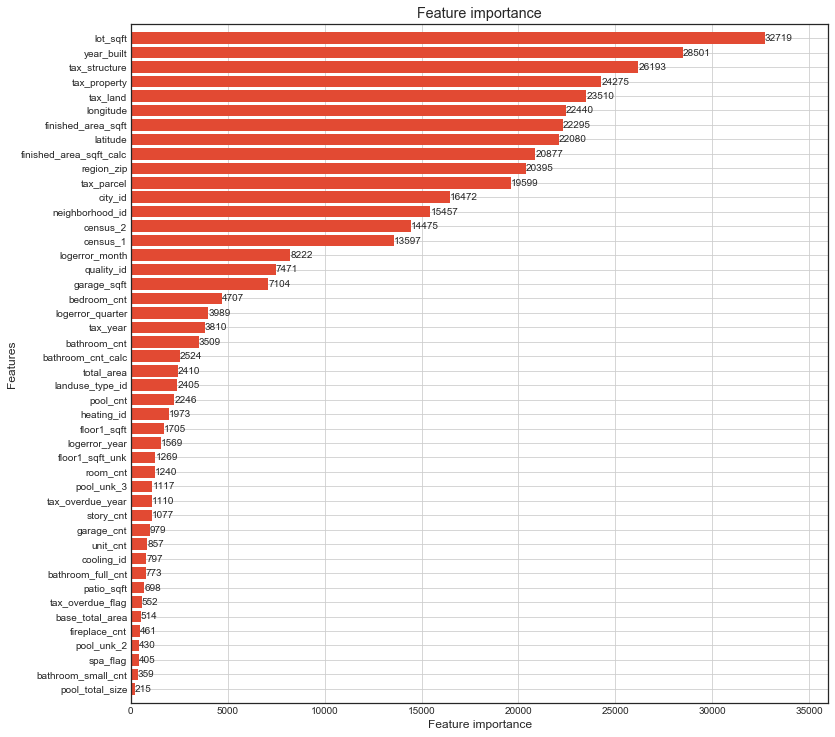

In [14]:
# Plot LightGBM feature importance
lgb.plot_importance(clf, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

In [42]:
%%time
def predict_and_export(clf, prop_2016, prop_2017, file_name):
    # Construct DataFrame for prediction results
    submission_2016 = pd.DataFrame()
    submission_2017 = pd.DataFrame()
    submission_2016['ParcelId'] = prop_2016.parcelid
    submission_2017['ParcelId'] = prop_2017.parcelid
    
    # Construct features and make prediction
    test_features_2016 = data_proc.drop_features(prop_2016)
    test_features_2017 = data_proc.drop_features(prop_2017)
    
#     test_dates = ['2016-10-01', '2016-11-01', '2016-12-01',
#                   '2017-10-01', '2017-11-01', '2017-12-01']
#     test_columns = ['201610', '201611', '201612',
#                     '201710', '201711', '201712']

    # Month and quarter features don't help performance much, but increases inference time by 3x
    # Consider not using them when producing submission file
    test_dates = ['2016-10-01', '2017-10-01']
    test_columns = ['201610', '201710']
    
    for d, c in zip(test_dates, test_columns):
        print("Start predicting for {}".format(c))
        
        if d[:4] == '2016':
            test_features = test_features_2016
        else:
            test_features = test_features_2017
        
        test_features['transactiondate'] = d
        test_features = data_proc.add_datetime_aggregate_features(test_features,
                                                                  logerror_year, logerror_month, logerror_quarter)
        pred_test = clf.predict(test_features)
        pred_test = [float(format(x, '.4f')) for x in pred_test]
        
        if d[:4] == '2016':
            submission_2016[c] = pred_test
        else:
            submission_2017[c] = pred_test
        
        print("Finished predicting for {}".format(c))
    
    submission_2016['201611'] = submission_2016['201610']
    submission_2016['201612'] = submission_2016['201610']
    submission_2017['201711'] = submission_2017['201710']
    submission_2017['201712'] = submission_2017['201710']
    
    submission = submission_2016.merge(how='inner', right=submission_2017, on='ParcelId')
    
    print("Length of submission DataFrame: {}".format(len(submission)))
    print("Submission header:")
    print(submission.head())
    submission.to_csv(file_name, index=False)
    return submission  # Return the results just in case we want to analyze or sanity check it

submission = predict_and_export(clf, prop_2016, prop_2017, 'data/test.csv')

Start predicting for 201610
Finished predicting for 201610
Start predicting for 201710
Finished predicting for 201710
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147 -0.0065 -0.0065 -0.0065 -0.0048 -0.0048 -0.0048
1  10759547 -0.0026 -0.0026 -0.0026 -0.0021 -0.0021 -0.0021
2  10843547  0.0168  0.0168  0.0168  0.0218  0.0218  0.0218
3  10859147  0.0291  0.0291  0.0291  0.0287  0.0287  0.0287
4  10879947 -0.0061 -0.0061 -0.0061 -0.0061 -0.0061 -0.0061
CPU times: user 27min 45s, sys: 13.5 s, total: 27min 58s
Wall time: 7min 37s


In [ ]:
# Sweep a single hyperparameter
def sweep_hyperparam(param_name, sweep):
    feature_names = [s for s in lgb_features.columns]
    categorical_indices = []
    for i, t in enumerate(lgb_features.dtypes):
        if t.name == 'category':
            categorical_indices.append(i)

    lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
    lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

    train_scores = []
    val_scores = []
    for p in sweep:
        print(p)
        np.random.seed(42)
        random.seed(36)
        params[param_name] = p
        clf = lgb.train(params, lgb_train_set, verbose_eval=False,
                    valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                    categorical_feature=categorical_indices)
        train_scores.append(abs(clf.predict(X_train) - y_train).mean() * 100)
        val_scores.append(abs(clf.predict(X_val) - y_val).mean() * 100)

    for i in range(len(sweep)):
        print("{}: train {}, val {}".format(sweep[i], train_scores[i], val_scores[i]))

sweep_hyperparam('learning_rate', [0.001, 0.0012, 0.0015, 0.0018, 0.002])